In [1]:
#pip3 install google.colab
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

###  Libraries

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors

import torch

import os
import sys

from Autoencoder import Autoencoder, CD_Autoencoder
from Datasets_Functions import *
from Visualization import Visualization
from Evaluations.Evaluation import Evaluator
from General_Functions import General_Functions

### Global Variables

In [3]:
path_to_module = './' # 'C:\\Users\\PAPASOFT INC\\Desktop\\SOFT_SIL'
sys.path.append(path_to_module)
os.environ['OMP_NUM_THREADS'] = '6'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

### Visualization

In [4]:
visualization = Visualization()

### ***LOAD DATASET***

In [5]:
hashmap = get_hashmap(path_to_module)
print(hashmap.keys())
dataset_name = 'emnist_balanced_letters'
dataset_properties = hashmap[dataset_name]
print(dataset_properties)
batch_size = dataset_properties['batch_size'] = 1024
n_clusters = dataset_properties['n_clusters'] = 10
dataloader, input_dim, data_np, labels = function_get_dataset(dataset_name, dataset_properties)
print('Data_Shape is:', input_dim)
print('Batches Number is:', len(dataloader))

dict_keys(['tcga', 'emnist_balanced_letters', 'emnist_mnist', 'emnist_balanced_digits', 'dermatology', 'ecoil', 'iris', 'rings', 'wine', 'australian', 'moons', 'squeezed_gauss', 'gauss_densities', 'pendigits', 'fashionmnist', '3dspheres', '20_newsgroups', 'coil20', 'cifar10', 'stl10', 'r15', 'r3'])
{'batch_size': 256, 'n_clusters': 37, 'module_name': 'Datasets.Datasets'}
Data_Shape is: 1
Batches Number is: 28


### Parameters

In [6]:
# Latent Dimension, Number of Channels and Negative Slope
latent_dim = 10
n_channels = 1
n_clusters = dataset_properties['n_clusters']

# Batch Size and Number of Clusters
batch_size = dataset_properties['batch_size']
negative_slope = 0

# Pre-Training Epochs and Learning Rate
n_pret_epochs = 100
pret_lr = 1e-3

# Lamdas, Training Epochs and Learning Rate
n_epochs = 100
lr = 1e-4
sil_lambda = 0.01
entr_lambda = 0.01

kmeans_initialization = True
pretrain = True
is_MLP_AE = False

### Create Autoencoder Model

In [7]:
if is_MLP_AE:
    autoencoder = Autoencoder(device=device, n_clusters=n_clusters, input_dim=input_dim, latent_dim=latent_dim, negative_slope=negative_slope)
    autoencoder.set_general_training_variables(dataloader=dataloader, batch_size=batch_size)
    autoencoder.set_pretraining_variables(n_pret_epochs=n_pret_epochs, pret_lr=pret_lr)
    autoencoder.set_training_variables(n_epochs=n_epochs, lr=lr, sil_lambda=sil_lambda, entr_lambda=entr_lambda)
    autoencoder.set_path_variables(path_to_module=path_to_module, dataset_name=dataset_name)
    autoencoder.set_path()
else:
    autoencoder = CD_Autoencoder(device=device, n_clusters=n_clusters, input_dim=input_dim, latent_dim=latent_dim, negative_slope=negative_slope, n_channels=n_channels)
    autoencoder.set_general_training_variables(dataloader=dataloader, batch_size=batch_size)
    autoencoder.set_pretraining_variables(n_pret_epochs=n_pret_epochs, pret_lr=pret_lr)
    autoencoder.set_training_variables(n_epochs=n_epochs, lr=lr, sil_lambda=sil_lambda, entr_lambda=entr_lambda)
    autoencoder.set_path_variables(path_to_module=path_to_module, dataset_name=dataset_name)
    autoencoder.set_path()
autoencoder = autoencoder.to(device)

In [8]:
autoencoder

CD_Autoencoder(
  (encoder_model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0, inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): LeakyReLU(negative_slope=0, inplace=True)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (7): LeakyReLU(negative_slope=0, inplace=True)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1152, out_features=10, bias=True)
    (11): Tanh()
    (12): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cluster_model): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=False)
  )
  (decoder_

### Pretrain Autoencoder Model

In [9]:
if(pretrain):
    autoencoder.pretrain_autoencoder()
    autoencoder.save_pretrained_weights()
else:
    model_save_path = autoencoder.data_dir_path + "/Weigths/autoencoder_weights.pth"
    autoencoder.load_state_dict(torch.load(model_save_path))
    norm_n_pret_epochs = autoencoder.n_pret_epochs  
    autoencoder.n_pret_epochs = 1
    autoencoder.pretrain_autoencoder()
    autoencoder.n_pret_epochs = norm_n_pret_epochs

Epoch: 0, Loss: 20.458656
Epoch: 1, Loss: 15.170491
Epoch: 2, Loss: 13.259875
Epoch: 3, Loss: 11.887637
Epoch: 4, Loss: 10.748350
Epoch: 5, Loss: 9.758828
Epoch: 6, Loss: 8.875162
Epoch: 7, Loss: 8.088344
Epoch: 8, Loss: 7.360731
Epoch: 9, Loss: 6.723468
Epoch: 10, Loss: 6.118297
Epoch: 11, Loss: 5.583579
Epoch: 12, Loss: 5.073392
Epoch: 13, Loss: 4.603617
Epoch: 14, Loss: 4.187459
Epoch: 15, Loss: 3.797982
Epoch: 16, Loss: 3.439886
Epoch: 17, Loss: 3.111632
Epoch: 18, Loss: 2.825296
Epoch: 19, Loss: 2.554711
Epoch: 20, Loss: 2.311151
Epoch: 21, Loss: 2.095514
Epoch: 22, Loss: 1.906223
Epoch: 23, Loss: 1.721660
Epoch: 24, Loss: 1.563430
Epoch: 25, Loss: 1.421660
Epoch: 26, Loss: 1.293551
Epoch: 27, Loss: 1.182520
Epoch: 28, Loss: 1.083359
Epoch: 29, Loss: 0.997131
Epoch: 30, Loss: 0.920055
Epoch: 31, Loss: 0.853873
Epoch: 32, Loss: 0.795693
Epoch: 33, Loss: 0.742579
Epoch: 34, Loss: 0.705192
Epoch: 35, Loss: 0.661817
Epoch: 36, Loss: 0.626647
Epoch: 37, Loss: 0.590933
Epoch: 38, Loss: 

In [10]:
# Initialize the clustering layer using k-means
if kmeans_initialization: autoencoder.kmeans_initialization(100)

ACC: 0.69 PUR: 0.73 NMI: 0.65 ARI: 0.55


In [20]:
"""
while True:
    # Code block to execute repeatedly
    autoencoder.trEpochs = 10
    autoencoder.train_autoencoder(silhouette_method = "default")
    visualization.makeExcel()
    #visualization.makePlot(useTSNE=False)
    #visualization.makePlot(useTSNE=True)
    visualization.plot_3D()

    # Check the condition to exit the loop
    if autoencoder.experimentName == "Experiment_400":
        break
"""
autoencoder.set_training_variables(n_epochs=200, lr=lr, sil_lambda=0.01, entr_lambda=0.01)

latent_data, labels, clustering = autoencoder.train_autoencoder()

cluster_centers = autoencoder.get_cluster_centers().cpu().detach().numpy()

Ep: 0 Rec L: 0.4091 Cl L: 0.1625 Entropy: 0.0318 SSil: 11.7490 SIL: 0.0000 ACC: 0.74 PUR: 0.78 NMI: 0.73 ARI: 0.64
Ep: 1 Rec L: 0.3996 Cl L: 0.1614 Entropy: 0.0316 SSil: 11.8581 SIL: 0.0000 ACC: 0.74 PUR: 0.78 NMI: 0.73 ARI: 0.64
Ep: 2 Rec L: 0.4002 Cl L: 0.1604 Entropy: 0.0314 SSil: 11.9587 SIL: 0.0000 ACC: 0.74 PUR: 0.78 NMI: 0.73 ARI: 0.64
Ep: 3 Rec L: 0.3982 Cl L: 0.1608 Entropy: 0.0310 SSil: 11.9206 SIL: 0.0000 ACC: 0.74 PUR: 0.78 NMI: 0.73 ARI: 0.64
Ep: 4 Rec L: 0.4026 Cl L: 0.1610 Entropy: 0.0308 SSil: 11.9036 SIL: 0.0000 ACC: 0.74 PUR: 0.78 NMI: 0.73 ARI: 0.64
Ep: 5 Rec L: 0.3979 Cl L: 0.1610 Entropy: 0.0305 SSil: 11.8975 SIL: 0.0000 ACC: 0.74 PUR: 0.78 NMI: 0.73 ARI: 0.64
Ep: 6 Rec L: 0.3981 Cl L: 0.1593 Entropy: 0.0306 SSil: 12.0689 SIL: 0.0000 ACC: 0.74 PUR: 0.78 NMI: 0.73 ARI: 0.64
Ep: 7 Rec L: 0.4007 Cl L: 0.1612 Entropy: 0.0303 SSil: 11.8772 SIL: 0.0000 ACC: 0.74 PUR: 0.78 NMI: 0.73 ARI: 0.64
Ep: 8 Rec L: 0.3979 Cl L: 0.1579 Entropy: 0.0302 SSil: 12.2067 SIL: 0.0000 ACC: 

Ep: 71 Rec L: 0.3912 Cl L: 0.1542 Entropy: 0.0212 SSil: 12.5780 SIL: 0.0000 ACC: 0.74 PUR: 0.78 NMI: 0.73 ARI: 0.64
Ep: 72 Rec L: 0.3936 Cl L: 0.1524 Entropy: 0.0212 SSil: 12.7599 SIL: 0.0000 ACC: 0.74 PUR: 0.78 NMI: 0.73 ARI: 0.64
Ep: 73 Rec L: 0.3907 Cl L: 0.1512 Entropy: 0.0209 SSil: 12.8844 SIL: 0.0000 ACC: 0.74 PUR: 0.78 NMI: 0.74 ARI: 0.64
Ep: 74 Rec L: 0.3901 Cl L: 0.1528 Entropy: 0.0209 SSil: 12.7197 SIL: 0.0000 ACC: 0.74 PUR: 0.78 NMI: 0.73 ARI: 0.64
Ep: 75 Rec L: 0.3878 Cl L: 0.1512 Entropy: 0.0206 SSil: 12.8847 SIL: 0.0000 ACC: 0.74 PUR: 0.78 NMI: 0.73 ARI: 0.64
Ep: 76 Rec L: 0.3948 Cl L: 0.1529 Entropy: 0.0207 SSil: 12.7131 SIL: 0.0000 ACC: 0.74 PUR: 0.78 NMI: 0.73 ARI: 0.64
Ep: 77 Rec L: 0.3927 Cl L: 0.1513 Entropy: 0.0206 SSil: 12.8728 SIL: 0.0000 ACC: 0.74 PUR: 0.78 NMI: 0.73 ARI: 0.64
Ep: 78 Rec L: 0.3963 Cl L: 0.1538 Entropy: 0.0207 SSil: 12.6202 SIL: 0.0000 ACC: 0.74 PUR: 0.78 NMI: 0.74 ARI: 0.64
Ep: 79 Rec L: 0.3907 Cl L: 0.1500 Entropy: 0.0205 SSil: 12.9959 SIL: 0.0

In [12]:
General_Functions().save_excel(autoencoder.data_dir_path, autoencoder.df_eval)

Directory './Results/emnist_balanced_letters/AE/100_Eps_ld_10_out_10_bs_1024_lr_0.0001_sil_lambda_0.01_entr_lambda_0.01' already exists.


C:\Users\PAPASOFT INC\Documents\GitHub\Soft-Silhouette\General_Functions.py:22: FutureWarning: Setting the `book` attribute is not part of the public API, usage can give unexpected or corrupted results and will be removed in a future version
  writer.book = workbook
C:\Users\PAPASOFT INC\Documents\GitHub\Soft-Silhouette\General_Functions.py:26: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


Directory './Results/emnist_balanced_letters/AE/100_Eps_ld_10_out_10_bs_1024_lr_0.0001_sil_lambda_0.01_entr_lambda_0.01/Experiments/No_TSNE' created successfully.


C:\Users\PAPASOFT INC\Documents\GitHub\Soft-Silhouette\Visualization.py:70: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(cluster_centers[:n_clusters, 0], cluster_centers[:n_clusters, 1], c='red', marker='x', s=500, edgecolors='black', label='Cluster Centers')


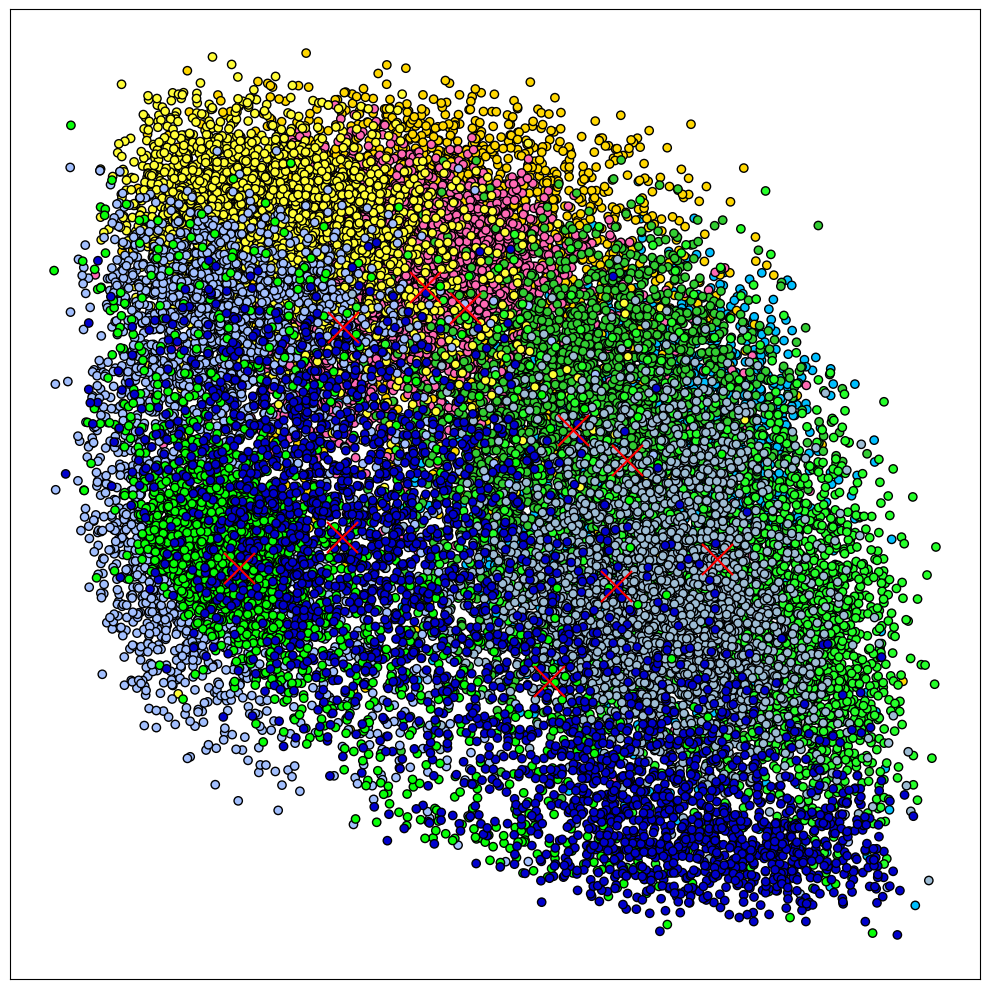

In [13]:
visualization.plot(latent_data, labels, clustering, cluster_centers, autoencoder.data_dir_path)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 28010 samples in 0.044s...
[t-SNE] Computed neighbors for 28010 samples in 1.796s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28010
[t-SNE] Computed conditional probabilities for sample 2000 / 28010
[t-SNE] Computed conditional probabilities for sample 3000 / 28010
[t-SNE] Computed conditional probabilities for sample 4000 / 28010
[t-SNE] Computed conditional probabilities for sample 5000 / 28010
[t-SNE] Computed conditional probabilities for sample 6000 / 28010
[t-SNE] Computed conditional probabilities for sample 7000 / 28010
[t-SNE] Computed conditional probabilities for sample 8000 / 28010
[t-SNE] Computed conditional probabilities for sample 9000 / 28010
[t-SNE] Computed conditional probabilities for sample 10000 / 28010
[t-SNE] Computed conditional probabilities for sample 11000 / 28010
[t-SNE] Computed conditional probabilities for sample 12000 / 28010
[t-SNE] Computed conditional probabilities for sam

C:\Users\PAPASOFT INC\Documents\GitHub\Soft-Silhouette\Visualization.py:43: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(tsne_embeddings[:n_clusters, 0], tsne_embeddings[:n_clusters, 1], c='red', marker='x', s=500, edgecolors='black', label='Cluster Centers')


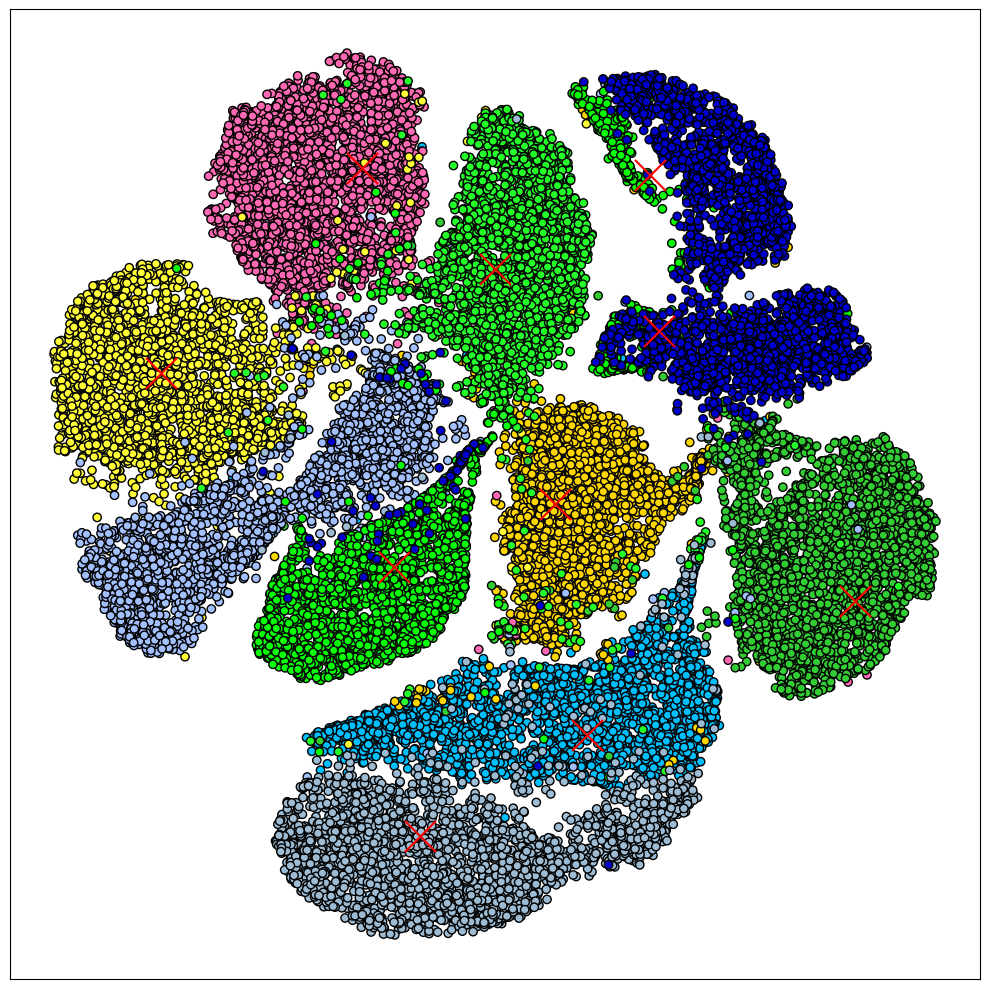

In [14]:
visualization.plot_tsne(latent_data, labels, clustering, cluster_centers, autoencoder.data_dir_path)

In [15]:
cluster_centers

array([[ 0.50800216,  0.28531674,  0.69015056, -0.619229  ,  1.036342  ,
        -1.000879  ,  1.0630463 ,  0.49841732, -0.05603592, -1.5718144 ],
       [-0.31253517,  1.1279974 ,  1.4750186 ,  0.70521134, -0.18803072,
         0.89147866,  0.32874128,  0.6781542 ,  0.80760723, -0.8800537 ],
       [ 0.3783672 , -1.1941911 ,  0.7917964 , -1.3570703 , -1.2056664 ,
        -0.01947567,  0.89691305,  0.16230808, -1.1007344 , -0.02136453],
       [-0.76572675,  0.8919629 , -0.49928972,  1.2970477 ,  0.90891135,
         0.6422228 , -1.0561231 , -0.62628114,  0.63114274,  0.53663504],
       [-0.76863056, -0.34477657,  0.03914483, -1.5201468 , -1.5250055 ,
        -0.01087781, -1.1985122 , -0.8936099 ,  0.08183307, -1.0820298 ],
       [ 0.74956703, -0.63863367, -0.16061987,  0.8603888 ,  0.61583304,
         1.1911851 ,  1.5192568 ,  0.98938286,  0.16662687,  1.175725  ],
       [ 0.8077083 ,  0.10686611,  0.34198716,  1.0130166 , -0.09594399,
        -0.9836936 ,  1.2957324 , -0.9612151 

In [16]:
clustering[0:100]

array([1, 2, 5, 3, 5, 3, 0, 7, 3, 7, 7, 2, 1, 3, 1, 9, 5, 3, 7, 8, 6, 3,
       4, 3, 0, 2, 3, 7, 6, 5, 2, 8, 8, 7, 7, 1, 0, 9, 1, 2, 5, 6, 3, 5,
       2, 3, 3, 4, 5, 2, 3, 5, 3, 6, 2, 9, 0, 7, 3, 7, 7, 1, 2, 7, 7, 8,
       9, 7, 4, 3, 7, 5, 5, 1, 8, 9, 0, 7, 4, 2, 6, 4, 4, 5, 1, 0, 7, 6,
       5, 3, 2, 3, 4, 5, 0, 1, 6, 1, 9, 2], dtype=int64)

In [17]:
latent_data

array([[-0.39381042,  0.86897373,  2.3559706 , ...,  0.6965206 ,
         0.6531843 , -0.5743103 ],
       [ 0.9412227 , -2.326601  ,  1.1103609 , ...,  0.1373904 ,
        -1.3999103 , -0.22849098],
       [ 0.58728975, -1.0574987 ,  0.16592805, ...,  1.3730807 ,
         0.18483838,  1.5298395 ],
       ...,
       [-1.5779233 ,  2.2354171 , -0.846492  , ..., -1.1698132 ,
         1.2770675 , -0.50341386],
       [ 0.61261404, -0.66368186,  0.41410422, ..., -1.3052975 ,
         0.281651  , -1.1205904 ],
       [-0.56022245,  0.83359903,  1.0138183 , ..., -0.3633899 ,
        -1.8329911 , -0.82470316]], dtype=float32)